# EWMA-Filter

Um die Lautstärke zu messen, brauche ich den Mittelwert, um den das Analogsignal (Auslenkung der Membran den Mikrofons) schwingt. Um diesen Mittelwert, der nicht konstant ist, zu errechnen nutze ich den EWMA-Filter. 

Mal angenommen, ich habe ein Signal, was aus mehreren Sinusschwingungen um einen unbekannten Mittelwert schwingt. Hier ein Beispiel:

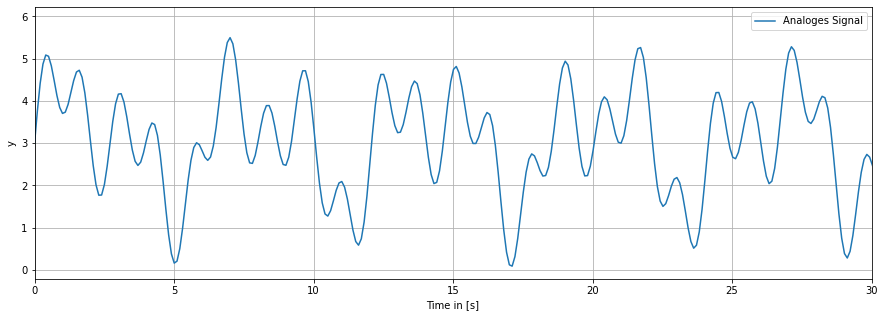

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(0, 100, 1000)
wave = lambda x: np.sin(x)+np.sin(2.1*x)+np.sin(4.7*x)+3
y = wave(x)

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(x,y, label="Analoges Signal")
ax.set_xlabel("Time in [s]")
ax.set_ylabel("y")
ax.set_xlim(0,30)
ax.legend(loc="upper right")
ax.grid(True)

Dieses Analogsignal wird z.B. 10 mal pro Sekunde abgetastet. Dadurch ergeben sich einige Messpunkte:

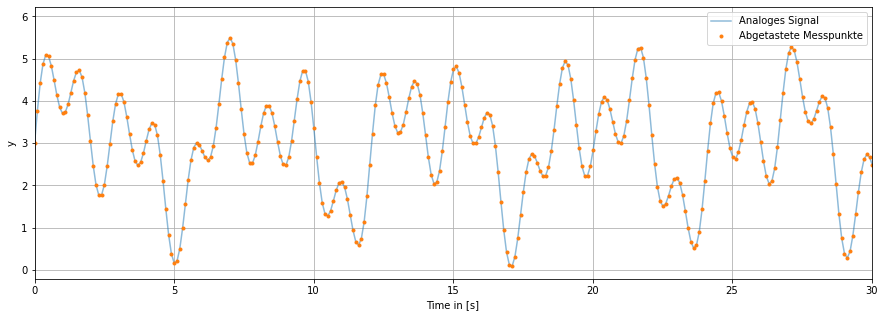

In [2]:
samples_per_s = 10
x_samp = np.linspace(0, 100, 100*samples_per_s)
y_samp = wave(x_samp)
fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(x,y, alpha=0.5, label="Analoges Signal")
ax.plot(x_samp,y_samp, ".", label="Abgetastete Messpunkte")
ax.set_xlabel("Time in [s]")
ax.set_ylabel("y")
ax.set_xlim(0,30)
ax.legend(loc="upper right")
ax.grid(True)

Der EWMA-Filter berechnet sich dann aus:

`y_mean = alpha * y_mean + (1-alpha) * y_val`

Je näher alpha an 1 ist, desto länger dauert es, bis der Mittelwert erreicht ist. Dafür ist dieser Mittelwert dann aber stabiler uns wird weniger vom tatsächlichen Signal beeinflusst. Welchen Wert man für Alpha festlegt, kann man ausprobieren.

Zusätzlich kann man den Filter mit einem Wert initialsieren, den man ungefähr als Mittelwert vermutet. Dadurch wird der tatsächliche Mittelwert schneller erreicht:

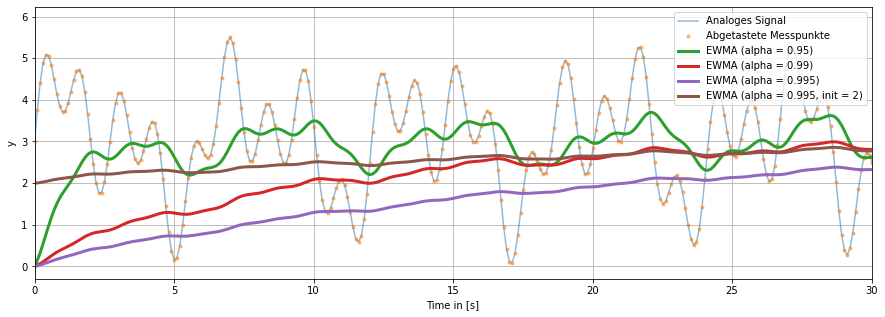

In [3]:
def calc_ewma(alpha, init=0):
    y_mean = np.array([init])
    for val in y_samp[:-1]:
        y_mean=np.append(y_mean, [alpha*y_mean[-1] + (1-alpha)*val])
    return y_mean
y_mean_095 = calc_ewma(0.95)   
y_mean_099 = calc_ewma(0.99)   
y_mean_0995 = calc_ewma(0.995) 
y_mean_0995_2 = calc_ewma(0.995, 2)        
fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(x,y, alpha=0.5, label="Analoges Signal")
ax.plot(x_samp,y_samp, ".", alpha=0.5, label="Abgetastete Messpunkte")
ax.plot(x_samp,y_mean_095, linewidth=3, label="EWMA (alpha = 0.95)")
ax.plot(x_samp,y_mean_099, linewidth=3, label="EWMA (alpha = 0.99)")
ax.plot(x_samp,y_mean_0995, linewidth=3, label="EWMA (alpha = 0.995)")
ax.plot(x_samp,y_mean_0995_2, linewidth=3, label="EWMA (alpha = 0.995, init = 2)")
ax.set_xlabel("Time in [s]")
ax.set_ylabel("y")
ax.set_xlim(0,30)
ax.legend(loc="upper right")
ax.grid(True)

Auf einen längeren Zeitraum sieht man:

* der tatsächliche Mittelwert von 3 wird von allen Filtern erreicht
* `alpha=0.95` schwingt noch recht stark
* `alpha=0.995` schwingt wesentlich weniger, braucht aber lange zum erreichen des Mittelwerts
* `alpha=0.995, init=2` erreicht den Mittelwert deutlich schneller, weil es bereits mit einer guten Schätzung initialisiert wurde

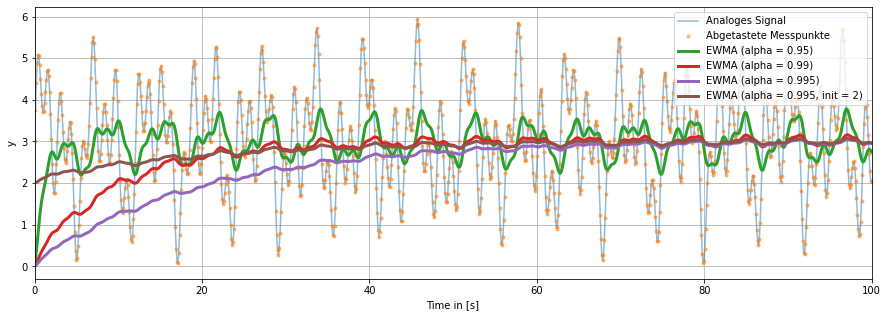

In [4]:
ax.set_xlim(0,100)
fig

Für die weitere Betrachtung wähle ich den `EWMA(alpha=0.995, init=2)`-Filter aus.

Um nun die mittlere Lautstärke in einem 10-Sekunden-Intervall zu berechnen, berechne ich die mittlere Abweichung vom Mittelwert:

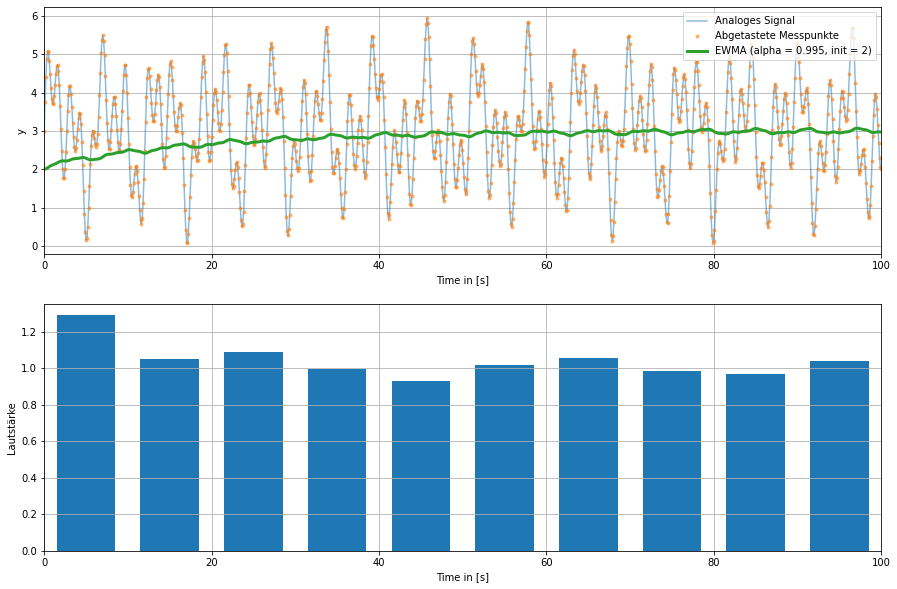

In [5]:
from math import fabs
interval_len = 100 # samples
vol_mean_arr = [0]
ewma = 2
vol_mean = 0
i = 0
for val in y_samp:
    ewma = 0.995*ewma + 0.005*val
    vol_mean += fabs(ewma-val)
    i += 1
    if i >= interval_len:
        vol_mean_arr.append(vol_mean/interval_len)
        vol_mean = 0
        i = 0

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(x,y, alpha=0.5, label="Analoges Signal")
ax[0].plot(x_samp,y_samp, ".", alpha=0.5, label="Abgetastete Messpunkte")
ax[0].plot(x_samp,y_mean_0995_2, linewidth=3, label="EWMA (alpha = 0.995, init = 2)")
ax[0].set_xlabel("Time in [s]")
ax[0].set_ylabel("y")
ax[0].set_xlim(0,100)
ax[0].legend(loc="upper right")
ax[0].grid(True)

ax[1].bar(np.linspace(0,100,11)-5, vol_mean_arr, 7)
ax[1].set_xlabel("Time in [s]")
ax[1].set_ylabel("Lautstärke")
ax[1].set_xlim(0,100)
ax[1].grid(True)


Der erste Lautstärkewert weicht noch recht stark ab, weil der EWMA-Filter noch nicht eingeschwungen ist. Die nachfolgenden Werte sind dann schon deutlich stabiler.

Es ist noch wichtig zu bemerken, dass der Lautstärkewert keine allgemeingültige Skala hat. Die Einheit "db" daran zu schreiben, wäre also falsch.